#  手書き文字(ひらがな73文字)認識モデルの構築

## 概要
MNIST手書き文字認識で0から9までのラベルを持った10種類の画像の分類を行ったが、更に応用して日本語手書き文字認識モデルを構築していく。構築には2種類のモデルを作成し、ひらがな73文字版の分類と、漢字300文字版の分類の2種類を行う。

> http://lab.ndl.go.jp/cms/hiragana73  
> http://lab.ndl.go.jp/cms/kanji300

In [1]:
# 画像や前処理周りのimport
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import time
from tqdm import tqdm_notebook as tqdm
import pandas as pd
%matplotlib inline

from sklearn.model_selection import train_test_split

# 深層学習周りのimport
import keras
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.utils import np_utils
from keras.optimizers import SGD, Adadelta, Adam, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

/Users/intel0tw5727/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# バージョン確認
import matplotlib
import sklearn
import tqdm as tm
print("numpy => {}".format(np.__version__))
print("matplotlib => {}".format(matplotlib.__version__))
print("pandas => {}".format(pd.__version__))
print("OpenCV => {}".format(cv2.__version__))
print("tqdm => {}".format(tm.__version__))
print("scikit-learn => {}".format(sklearn.__version__))
print("keras => {}".format(keras.__version__))

numpy => 1.14.0
matplotlib => 2.1.2
pandas => 0.22.0
OpenCV => 3.4.1
tqdm => 4.23.4
scikit-learn => 0.19.1
keras => 2.2.0


## データセット文字コード対応表の読み込み

In [3]:
jp_char_df = pd.read_csv("../data/hiragana_table.csv")

In [4]:
jp_char_df.head()

,char,dir,img_num
0,あ,U3042,"1,208"
1,い,U3044,"1,122"
2,う,U3046,"1,148"
3,え,U3048,"1,077"
4,お,U304A,"1,283"


In [5]:
# 漢字データセット総数: 146,157
# 1ラベル約100~1000程度
dir_path = "../data/hiragana73"
img_list = []
label_list = []

for root, dirs, files in tqdm(os.walk(dir_path)):
    if len(files) == 0:
        labels = dirs
        labels_dict = dict(zip([_ for _ in range(len(labels))], labels))
    else:
        tmp = []
        idx = jp_char_df[jp_char_df.dir == root.split("/")[-1]].index.values[0]
        for file in files:
            img_list.append(cv2.imread(os.path.join(root, file)))
            label_list.append(idx)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

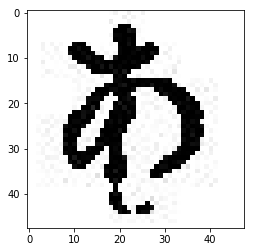

In [6]:
plt.imshow(img_list[0])

In [7]:
img_list[0].shape

(48, 48, 3)

In [8]:
len(img_list)

80000

## データ前処理

このままでは学習に時間がかかるため、前処理時点で訓練データとテストデータを加工して、使いやすくするために3つの処理を行います。

- 画像のグレースケール化
- 画像のリサイズ
- 画像の2値化

HBox(children=(IntProgress(value=0, max=80000), HTML(value='')))

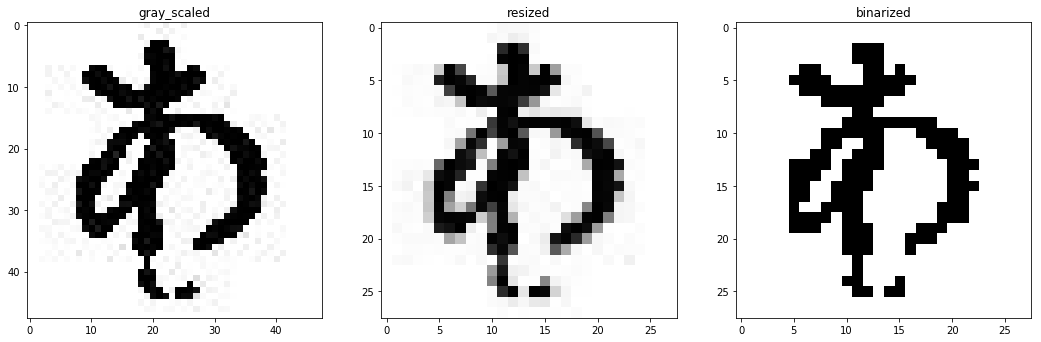

In [9]:
img_prop_list = []
flag = False
for img in tqdm(img_list):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # グレースケール化
    img_resize = cv2.resize(img_gray, (28,28)) # リサイズ
    _, img_prop = cv2.threshold(img_resize, 0, 255, \
                                cv2.THRESH_BINARY + cv2.THRESH_OTSU) # 2値化
    
    if flag == False: 
        # 初回のみplot
        fig, ax = plt.subplots(1, 3, figsize=(18,8))
        titles = ["gray_scaled", "resized", "binarized"]
        imgs = [img_gray, img_resize, img_prop]
        for n, (k, v) in enumerate(zip(titles, imgs)):
            ax[n].imshow(v, cmap="gray")
            # ax[n].axis("off")
            ax[n].set_title("{}".format(k))
        flag = True

    img_prop_list.append(img_prop)
    
# img_list はもう使わないのでメモリから開放する
# del img_list

## データの準備

In [10]:
# X, y = np.array(img_list), label_list
X, y = np.array(img_prop_list), label_list

In [11]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=98, shuffle=True)

# X_train = X_train.reshape(len(X_train), X_train[0].shape[0], X_train[0].shape[1], 3)
X_train = X_train.reshape(len(X_train), X_train[0].shape[0], X_train[0].shape[1], 1)

# X_test = X_test.reshape(len(X_test), X_test[0].shape[0], X_test[0].shape[1], 3)
X_test = X_test.reshape(len(X_test), X_test[0].shape[0], X_test[0].shape[1], 1)

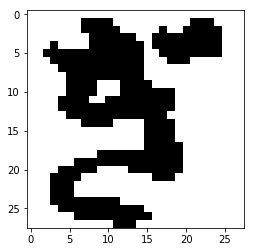

In [12]:
# trainデータの1枚を確認
plt.imshow(X_train[0].reshape(28, 28), cmap="gray")

In [13]:
# testデータの1枚を確認
jp_char_df.loc[y_train[0]]["char"]

'ぎ'

In [14]:
print("X_train.shape -> {}".format(X_train.shape))
print("X_test.shape -> {}".format(X_test.shape))

X_train.shape -> (64000, 28, 28, 1)
X_test.shape -> (16000, 28, 28, 1)


In [15]:
nb_classes = len(labels)
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [16]:
print("y_train.shape -> {}".format(len(y_train)))
print("y_test.shape -> {}".format(len(y_test)))

y_train.shape -> 64000
y_test.shape -> 16000


In [17]:
input_shape = X_train.shape[1:]

## モデルの構築

In [18]:
model = Sequential()

"""
model.add()の中にConv2DやMaxPooling2Dをいれてモデルを作ってみよう

今回使用する関数一覧

model.add(Dense(次元数, activation=活性化関数))
model.add(Flatten()) # 畳み込みし終えた後全結合層につなげるときに使おう
model.add(Conv2D(フィルター数, 
                                    kernel_size=(フィルターの縦サイズ, フィルターの横サイズ),
                                    activation=活性化関数,
                                    input_shape=input_shape)) #input_shapeは最初のみ使用
model.add(MaxPooling2D(pool_size=(プーリングの縦サイズ, プーリングの横サイズ))))
model.add(Dropout(0から1までの数値)) # 学習するパーセプトロンのうち使用しない割合を設定

その他、調べてみて便利な関数があればぜひ追加してみよう
"""

model.add(Conv2D(28, kernel_size=(3, 3),activation='relu', padding="same", input_shape=input_shape))
model.add(Conv2D(28, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(56, kernel_size=(3, 3),activation='relu', padding="same"))
model.add(Conv2D(56, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(112, kernel_size=(3, 3),activation='relu', padding="same"))
model.add(Conv2D(112, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Fully connected layer #2
model.add(Dense(len(labels), activation="softmax"))

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 28)        280       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 28)        7084      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 28)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 56)        14168     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 56)        28280     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 56)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 112)         56560     
__________

## モデルの読み込み

model = model_from_json(open("../models/kanji_cnn.json", "r").read())
model.load_weights("../params/kanji_cnn_best_weight.hdf5")

## モデルのコンパイル

In [20]:
"""
モデルを評価する関数をmodel.compile()で定義しよう

実際にmodel.compileの中にはこのようにします

model.compile(loss=誤差関数,
             optimizer=最適化関数,
             metrics=['accuracy']
             )
             
誤差関数
・categorical_crossentropy

最適化関数(好きなものを選ぼう)
・SGD
・Adadelta
・Adam
・RMSprop

評価指標
・accuracy
"""

model.compile(loss="categorical_crossentropy", # 誤差(損失)関数
             optimizer="RMSprop", # 最適化関数
             metrics=["accuracy"] # 評価指標
             )

## 初期モデル・パラメータを保存

In [21]:
!mkdir ../models

mkdir: ../models: File exists


In [22]:
init_weights_path = '../models/hiragana_cnn_init_weight.hdf5'
best_weights_path = '../models/hiragana_cnn_best_weight.hdf5'
model.save_weights(init_weights_path, overwrite=True)
model.save_weights(best_weights_path, overwrite=True)

In [23]:
model_path = '../models/hiragana_cnn.json'
model_json = model.to_json()
open(model_path, 'w').write(model_json)

5529

## 学習中のコールバックの設定

In [24]:
callbacks = [
    EarlyStopping(monitor='val_acc', patience=2,mode='max',verbose=1),
    ModelCheckpoint(best_weights_path,monitor='val_acc', save_best_only=True, 
        mode='max',verbose=0)
]

## 学習

In [25]:
tic = time.time()

history = model.fit(X_train, Y_train,
                    batch_size=512,
                    epochs=100,
                    verbose=1,
                    validation_data=(X_test, Y_test),
                    callbacks=callbacks)

toc = time.time()

print("Execution time: {0:.2f} [sec]".format(toc - tic))

Train on 64000 samples, validate on 16000 samples
Epoch 1/100
64000/64000 [==============================] - 324s 5ms/step - loss: 2.3326 - acc: 0.5644 - val_loss: 0.1114 - val_acc: 0.9648
Epoch 2/100
64000/64000 [==============================] - 329s 5ms/step - loss: 0.1749 - acc: 0.9494 - val_loss: 0.0673 - val_acc: 0.9789
Epoch 3/100
64000/64000 [==============================] - 332s 5ms/step - loss: 0.0961 - acc: 0.9711 - val_loss: 0.0435 - val_acc: 0.9854
Epoch 4/100
64000/64000 [==============================] - 335s 5ms/step - loss: 0.0696 - acc: 0.9781 - val_loss: 0.0445 - val_acc: 0.9861
Epoch 5/100
 1536/64000 [..............................] - ETA: 4:35 - loss: 0.0523 - acc: 0.9824

KeyboardInterrupt: 

## 学習結果の可視化

In [26]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.04443741778436379
Test accuracy: 0.984625


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('Training performance (Loss)')
ax[0].plot(history.epoch, history.history['loss'], label='loss')
ax[0].plot(history.epoch, history.history['val_loss'], label='val_loss')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[0].legend()

ax[1].set_title('Training performance (Accuracy)')
ax[1].plot(history.epoch, history.history['acc'], label='acc')
ax[1].plot(history.epoch, history.history['val_acc'], label='val_acc')
ax[1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1].legend(loc='best')

In [ ]:
history_df = pd.DataFrame([history.history["loss"],history.history["acc"],history.history["val_loss"],history.history["val_acc"]])
history_df.index = ["loss", "acc", "val_loss", "val_acc"]

In [ ]:
history_df.T.to_csv("../data/learning_result.csv", index=False)

## 予測の可視化

In [27]:
Y_test_pred = model.predict(X_test)

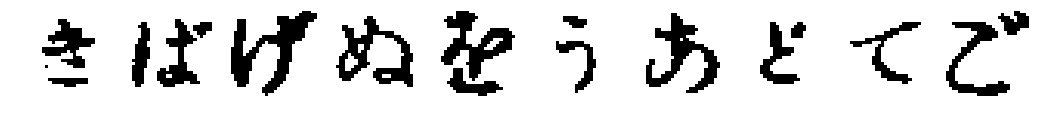

In [32]:
# テストデータの可視化
fig, ax = plt.subplots(1, 10, figsize=(18, 8))

for n, ii in enumerate(range(10,20)):
    ax[n].imshow(X_test[ii].reshape(28, 28), cmap='gray') #iiの値+nでn番目以降のテストデータを出力する．
    ax[n].axis('off')

In [33]:
# 予測の可視化
[jp_char_df.loc[y_pred.argmax()]["char"] for y_pred in Y_test_pred[10:20]]

['き', 'ば', 'げ', 'ぬ', 'を', 'う', 'あ', 'ど', 'て', 'ご']